# Kaggle实战-房价预测

In [4]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save

In [5]:
# 将数据集名称的字符串映射到数据集相关的二元组上
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

+ 下⾯的download函数⽤来下载数据集，将数据集缓存在本地⽬录（默认情况下为../data）中，并返回下载⽂件的名称。如果缓存⽬录中已经存在此数据集⽂件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使⽤缓存的⽂件，以避免重复的下载。


In [6]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    assert name in DATA_HUB, f'{name} 不存在于 {DATA_HUB}'
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [7]:
#  下载并解压文件
def download_extract(name, folder=None): #@save
    # 下载并解压zip/tar格式文件
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    # 下载DATA_HUB中的所有文件
    for name in DATA_HUB:
        download(name)

## 1.访问和读取数据集

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
DATA_HUB['kaggle_house_train'] = ( #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')


In [9]:
# 使用pandas加载上述数据
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [10]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [11]:
print(train_data.iloc[0:-1])

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  1455          20       FV         62.0     7500   Pave  Pave      Reg   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

In [12]:
# 删除第一列的ID属性
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))

## 2.数据预处理

In [14]:
# 若无法获取测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 在标准化数据之后，将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [15]:
# 处理离散值，将特征用独热编码替换
# 例如MSZoning包含RL和Rm，此时将该特征划分为两个新的指标属性，并用0/1表示其是否存在
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

+ 可以看到此转换会将特征的总数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表⽰⽤于训练。


In [17]:
# 获取训练数据条数
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32 # 将最后价格数据转换为一列
)


## 3. 训练

In [18]:
loss = nn.MSELoss()
in_features = train_features.shape[1] # 输入特征数

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 1) # 输入为房子售卖特征，输出为房子销售价格
    )
    return net


In [19]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                          torch.log(labels)))
    return rmse.item()

In [20]:
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = learning_rate,
        weight_decay = weight_decay
    )
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad() # 先梯度清零
            l = loss(net(X), y)
            l.backward() # 反向传播求梯度
            optimizer.step() # 更新参数
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

+ K折交叉验证

In [21]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            # 选择这部分数据为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            # 这部分数据为训练集
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

+ 在K折交叉验证中训练K次后，返回训练和验证误差的平均值

In [22]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
          batch_size):
    train_l_sum, valid_l_sum = 0, 0 # 训练损失和，验证损失和
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(
                list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                legend=['train', 'valid'], yscale='log'
            )
            print(f'折{i+1}，训练log rmse{float(valid_ls[-1]):f}')
        return train_l_sum / k, valid_l_sum / k

## 4. 模型选择

折1，训练log rmse0.157414
5-折验证：平均训练log rmse：0.033958,平均验证log rmse：0.031483


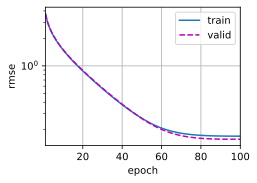

In [23]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                         weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'
     f'平均验证log rmse：{float(valid_l):f}')